# Example 9: Analyzing the Results of the High-Lat Run

In this Example we analyze the results of an MPI run of NPTFit performed over high latitudes.

The example batch script we provide, `Example9_HighLat_Batch.batch` is for SLURM. This calls the run file `Example9_HighLat_Run.py` using MPI, and is an example of how to perform a more realistic analysis using NPTFit.

**NB:** The batch file must be run before this notebook.

**NB:** this example makes use of the Fermi Data, which needs to already be installed. See Example 1 for details.

In this example, we model the source-count function as a triply-broken power law. In detail, the source count function is then:

$$ \frac{dN}{dS} = A \left\{ \begin{array}{lc} \left( \frac{S}{S_{b,1}} \right)^{-n_1}, & S \geq S_{b,1} \\ \left(\frac{S}{S_{b,1}}\right)^{-n_2}, & S_{b,1} > S \geq S_{b,2} \\ \left( \frac{S_{b,2}}{S_{b,1}} \right)^{-n_2} \left(\frac{S}{S_{b,2}}\right)^{-n_3}, & S_{b,2} > S \geq S_{b,3} \\ \left( \frac{S_{b,2}}{S_{b,1}} \right)^{-n_2} \left( \frac{S_{b,3}}{S_{b,2}} \right)^{-n_3} \left(\frac{S}{S_{b,3}}\right)^{-n_4}, & S_{b,3} > S \end{array} \right. $$

and is thereby described by the following eight parameters:

$$ \theta  = \left[ A, n_1, n_2, n_3, n_4, S_b^{(1)}, S_b^{(2)}, S_b^{(3)} \right]\,. $$

This provides an example of a more complicated source count function, and also explains why the run needs MPI.

In [1]:
# Import relevant modules

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import corner
import matplotlib.pyplot as plt
from matplotlib import rcParams

from NPTFit import nptfit # module for performing scan
from NPTFit import create_mask as cm # module for creating the mask
from NPTFit import dnds_analysis # module for analysing the output
from NPTFit import psf_correction as pc # module for determining the PSF correction

from __future__ import print_function

In [2]:
# Set plotting options
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20
rcParams['axes.labelsize'] = 20
rcParams['axes.titlesize'] = 20
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'CMU Serif'
rcParams['figure.figsize'] = (7,5)
rcParams['legend.fontsize'] = 16
# rcParams['text.usetex'] = True

## Load in scan

We need to create an instance of `nptfit.NPTF` and load in the scan performed using MPI.

In [3]:
n = nptfit.NPTF(tag='HighLat_Example')

In [4]:
fermi_data = np.load('fermi_data/fermidata_counts.npy')
fermi_exposure = np.load('fermi_data/fermidata_exposure.npy')
n.load_data(fermi_data, fermi_exposure)

In [5]:
analysis_mask = cm.make_mask_total(band_mask = True, band_mask_range = 50)
n.load_mask(analysis_mask)

In [6]:
dif = np.load('fermi_data/template_dif.npy')
iso = np.load('fermi_data/template_iso.npy')

n.add_template(dif, 'dif')
n.add_template(iso, 'iso')

In [7]:
n.add_poiss_model('dif','$A_\mathrm{dif}$', [0,20], False)
n.add_poiss_model('iso','$A_\mathrm{iso}$', [0,5], False)

In [8]:
n.add_non_poiss_model('iso',
                      ['$A^\mathrm{ps}_\mathrm{iso}$',
                      '$n_1$','$n_2$','$n_3$','$n_4$',
                      '$S_b^{(1)}$','$S_b^{(2)}$','$S_b^{(3)}$'],
                      [[-6,2],
                      [2.05,5],[1.0,3.5],[1.0,3.5],[-1.99,1.99],
                      [30,80],[1,30],[0.1,1]],
                      [True,False,False,False,False,False,False,False])

In [9]:
pc_inst = pc.psf_correction(psf_sigma_deg=0.1812)
f_ary, df_rho_div_f_ary = pc_inst.f_ary, pc_inst.df_rho_div_f_ary

Loading the psf correction from: /group/hepheno/smsharma/NPTFit-Python3/examples/psf_dir/gauss_128_0.181_10_50000_1000_0.01.npy


In [10]:
n.configure_for_scan(f_ary=f_ary, df_rho_div_f_ary=df_rho_div_f_ary, nexp=5)

The number of parameters to be fit is 10


Finally, load the completed scan performed using MPI.

In [11]:
n.load_scan()

  analysing data from /group/hepheno/smsharma/NPTFit-Python3/examples/chains/HighLat_Example/.txt


## Analysis

As in Example 8 we first initialize the analysis module. We will provide the same basic plots as in that notebook, where more details on each option is provided.

In [12]:
an = dnds_analysis.dnds_analysis(n)

### 1. Make triangle plots

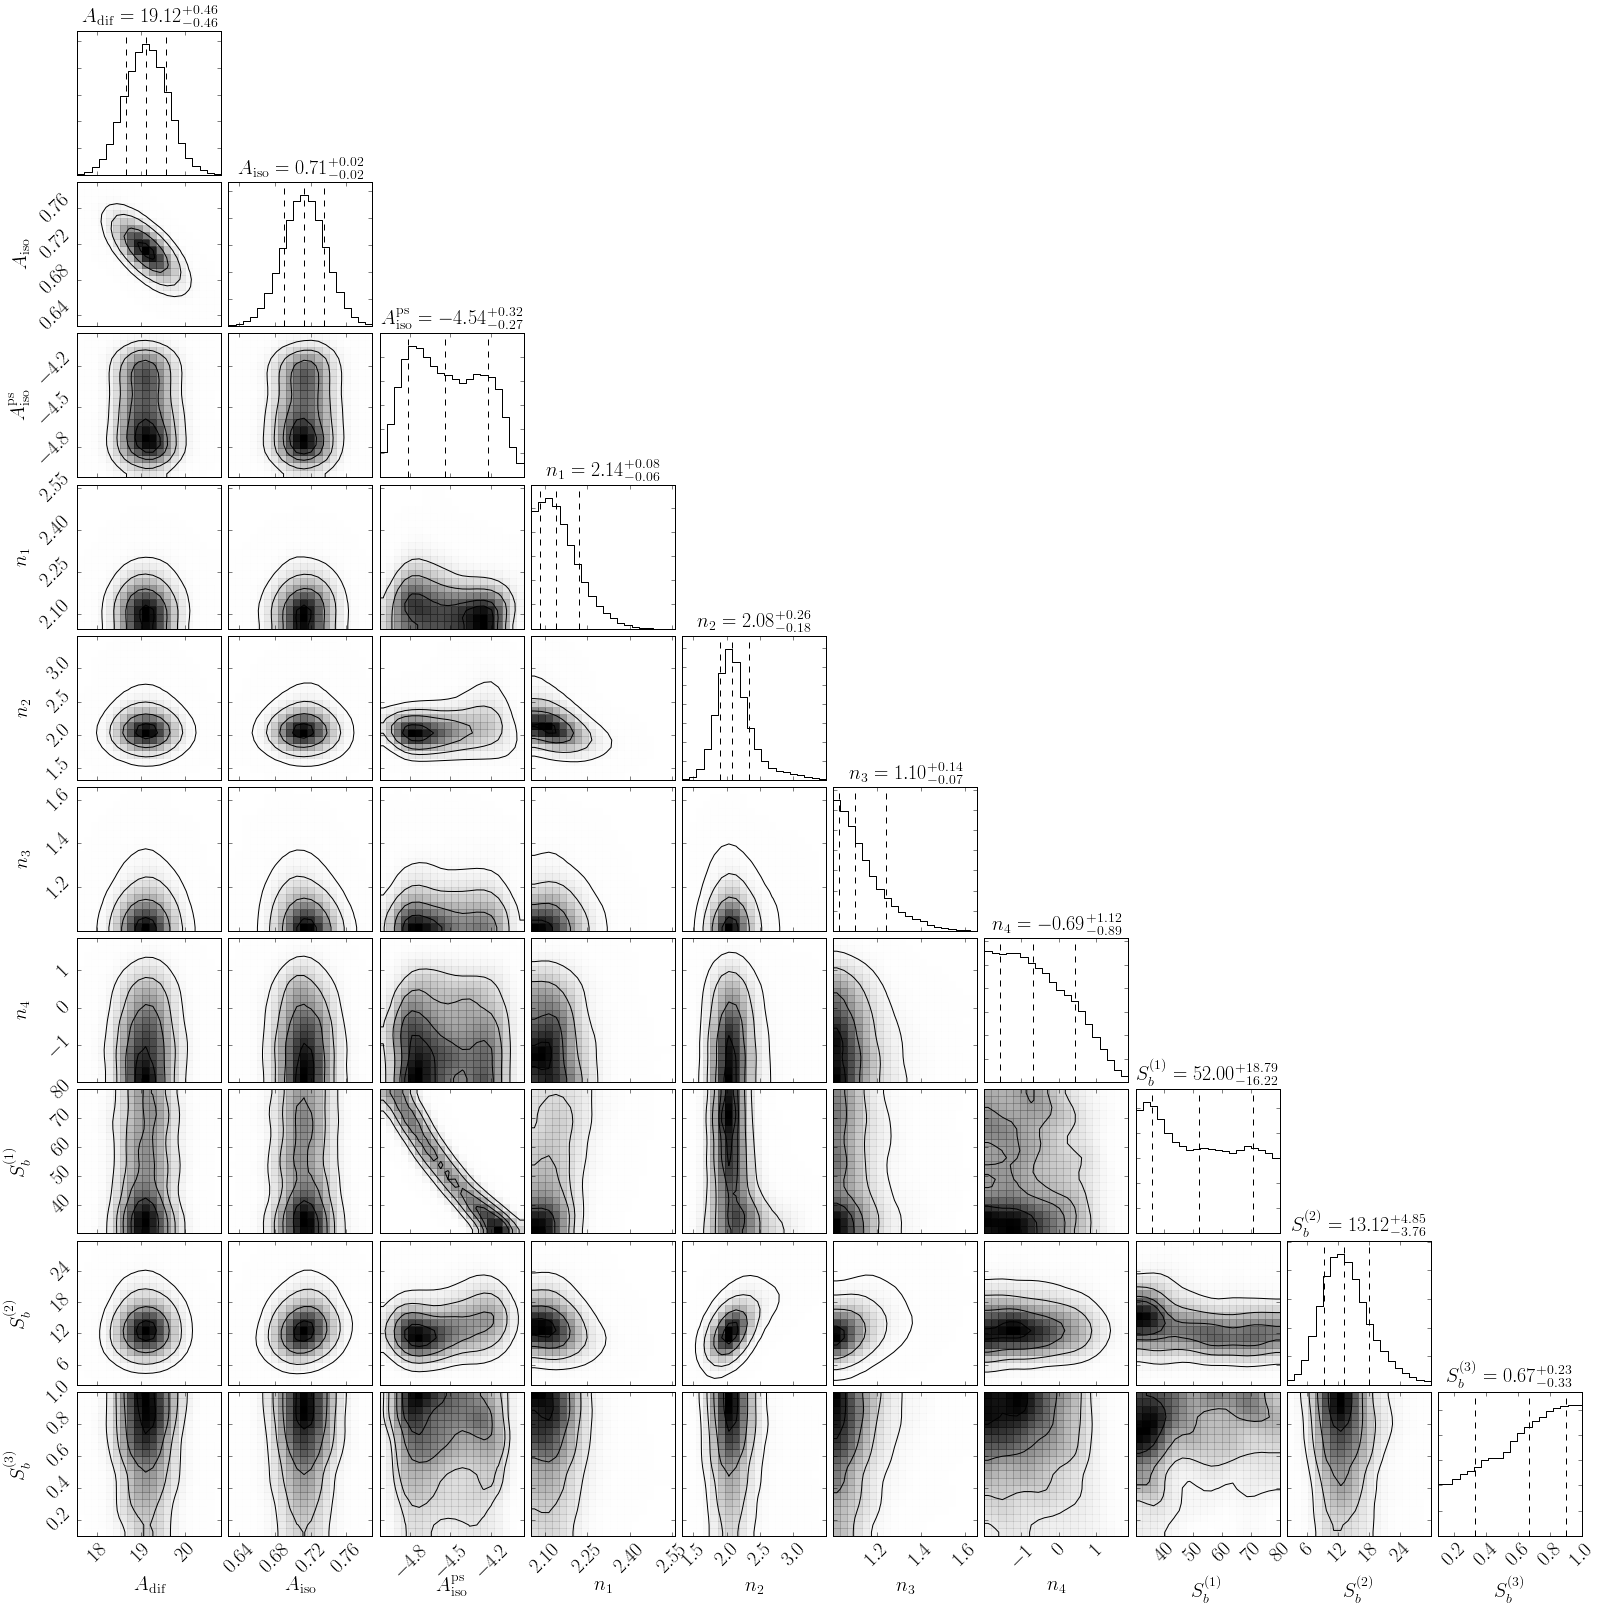

In [13]:
an.make_triangle()

### 2. Get Intensities

In [14]:
print("Iso NPT Intensity",corner.quantile(an.return_intensity_arrays_non_poiss('iso'),[0.16,0.5,0.84]), "ph/cm^2/s")
print("Iso PT Intensity",corner.quantile(an.return_intensity_arrays_poiss('iso'),[0.16,0.5,0.84]), "ph/cm^2/s")
print("Dif PT Intensity",corner.quantile(an.return_intensity_arrays_poiss('dif'),[0.16,0.5,0.84]), "ph/cm^2/s")

Iso NPT Intensity [  1.03633880e-07   1.10949453e-07   1.18316858e-07] ph/cm^2/s
Iso PT Intensity [  1.57029120e-07   1.62092569e-07   1.67278011e-07] ph/cm^2/s
Dif PT Intensity [  1.99021266e-07   2.03966592e-07   2.08820326e-07] ph/cm^2/s


### 3. Plot Source Count Distributions 

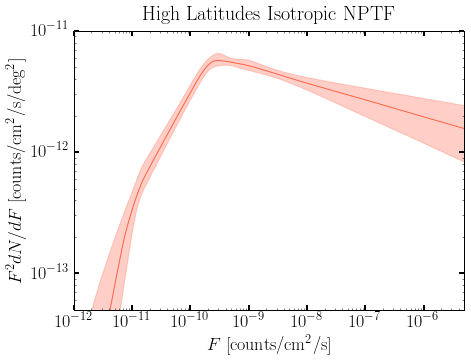

In [15]:
an.plot_source_count_median('iso',smin=0.01,smax=1000000,nsteps=10000,color='tomato',spow=2)
an.plot_source_count_band('iso',smin=0.01,smax=1000000,nsteps=10000,qs=[0.16,0.5,0.84],color='tomato',alpha=0.3,spow=2)

plt.yscale('log')
plt.xscale('log')
plt.xlim([1e-12,5e-6])
plt.ylim([5e-14,1e-11])
plt.tick_params(axis='x', length=5, width=2, labelsize=18)
plt.tick_params(axis='y', length=5, width=2, labelsize=18)
plt.ylabel('$F^2 dN/dF$ [counts/cm$^2$/s/deg$^2$]', fontsize=18)
plt.xlabel('$F$  [counts/cm$^2$/s]', fontsize=18)
plt.title('High Latitudes Isotropic NPTF', y=1.02)

### 4. Plot Intensity Fractions

(0, 80)

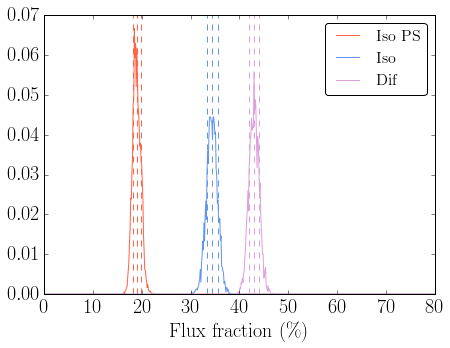

In [16]:
an.plot_intensity_fraction_non_poiss('iso', bins=800, color='tomato', label='Iso PS')
an.plot_intensity_fraction_poiss('iso', bins=800, color='cornflowerblue', label='Iso')
an.plot_intensity_fraction_poiss('dif', bins=800, color='plum', label='Dif')
plt.xlabel('Flux fraction (%)')
plt.legend(fancybox = True)
plt.xlim(0,80)

### 5. Access Parameter Posteriors

#### Poissonian parameters

In [17]:
Aiso_poiss_post = an.return_poiss_parameter_posteriors('iso')
Adif_poiss_post = an.return_poiss_parameter_posteriors('dif')

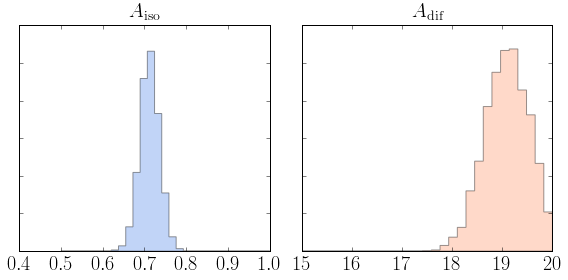

In [18]:
f, axarr = plt.subplots(1, 2);
f.set_figwidth(8)
f.set_figheight(4)


axarr[0].hist(Aiso_poiss_post, histtype='stepfilled', color='cornflowerblue', bins=np.linspace(.5,1,30),alpha=0.4);
axarr[0].set_title('$A_\mathrm{iso}$')
axarr[1].hist(Adif_poiss_post, histtype='stepfilled', color='lightsalmon', bins=np.linspace(15,20,30),alpha=0.4);
axarr[1].set_title('$A_\mathrm{dif}$')

plt.setp([a.get_yticklabels() for a in axarr[:]], visible=False);

plt.tight_layout()

#### Non-poissonian parameters

In [19]:
Aiso_non_poiss_post, n_non_poiss_post, Sb_non_poiss_post = an.return_non_poiss_parameter_posteriors('iso')

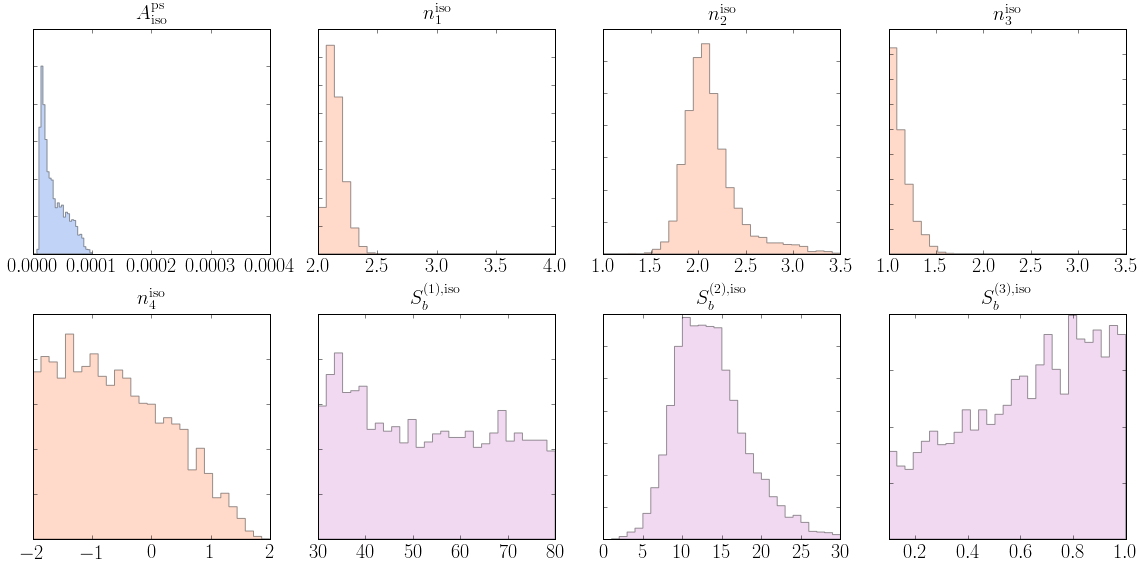

In [20]:
f, axarr = plt.subplots(2, 4);
f.set_figwidth(16)
f.set_figheight(8)

axarr[0, 0].hist(Aiso_non_poiss_post, histtype='stepfilled', color='cornflowerblue', bins=np.linspace(0,.0001,30),alpha=0.4);
axarr[0, 0].set_title('$A_\mathrm{iso}^\mathrm{ps}$')
axarr[0, 1].hist(n_non_poiss_post[0], histtype='stepfilled', color='lightsalmon', bins=np.linspace(2,4,30),alpha=0.4);
axarr[0, 1].set_title('$n_1^\mathrm{iso}$')
axarr[0, 2].hist(n_non_poiss_post[1], histtype='stepfilled', color='lightsalmon', bins=np.linspace(1,3.5,30),alpha=0.4);
axarr[0, 2].set_title('$n_2^\mathrm{iso}$')
axarr[0, 3].hist(n_non_poiss_post[2], histtype='stepfilled', color='lightsalmon', bins=np.linspace(1,3.5,30),alpha=0.4);
axarr[0, 3].set_title('$n_3^\mathrm{iso}$')
axarr[1, 0].hist(n_non_poiss_post[3], histtype='stepfilled', color='lightsalmon', bins=np.linspace(-2,2,30),alpha=0.4);
axarr[1, 0].set_title('$n_4^\mathrm{iso}$')
axarr[1, 1].hist(Sb_non_poiss_post[0], histtype='stepfilled', color='plum', bins=np.linspace(30,80,30),alpha=0.4);
axarr[1, 1].set_title('$S_b^{(1), \mathrm{iso}}$')
axarr[1, 2].hist(Sb_non_poiss_post[1], histtype='stepfilled', color='plum', bins=np.linspace(1,30,30),alpha=0.4);
axarr[1, 2].set_title('$S_b^{(2), \mathrm{iso}}$')
axarr[1, 3].hist(Sb_non_poiss_post[2], histtype='stepfilled', color='plum', bins=np.linspace(0.1,1,30),alpha=0.4);
axarr[1, 3].set_title('$S_b^{(3), \mathrm{iso}}$')

plt.setp(axarr[0, 0], xticks=[x*.0001 for x in range(5)])
plt.setp(axarr[1, 0], xticks=[x*1.-2.0 for x in range(5)])
plt.setp(axarr[1, 3], xticks=[x*0.2+0.2 for x in range(5)])
plt.setp([a.get_yticklabels() for a in axarr[:, 0]], visible=False);
plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False);
plt.setp([a.get_yticklabels() for a in axarr[:, 2]], visible=False);
plt.setp([a.get_yticklabels() for a in axarr[:, 3]], visible=False);
plt.tight_layout()